In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PyTorchAberrations.aberration_layers import PhasePlane

## 1. Effect of a phase plane

The number of internal degrees of freedom corresponds to the number of independent areas of 
size `corr_length` in the total area.

To see the effect, we initialize the phase values to random values (`init_to_zero = False`). 
In real optimization, it is probably better to set them to zero.

<IPython.core.display.Javascript object>


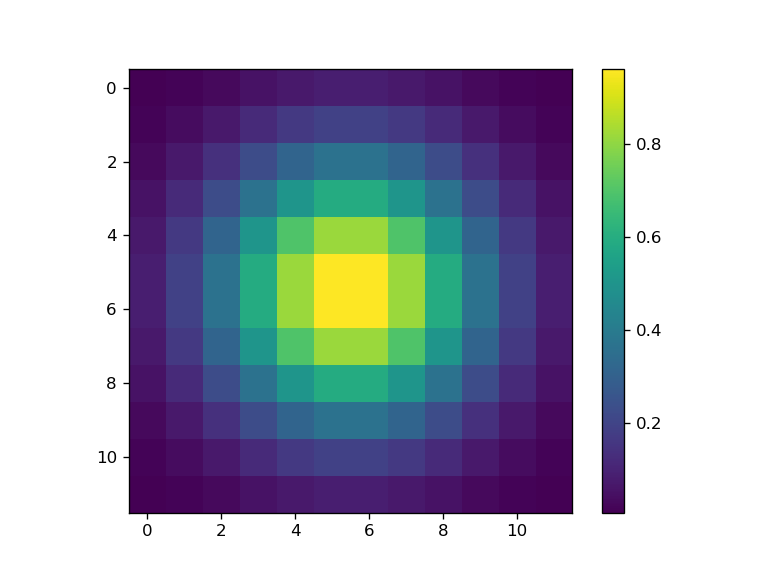

In [3]:
shape = (100,100)
pp = PhasePlane(shape = shape, corr_length = 5, dx = 1, init_to_zero = False)

input = torch.ones(*shape, dtype = torch.complex64)
C = pp(input)

plt.figure()
plt.imshow(pp.K.detach().numpy()[0,0,...])
plt.colorbar()


## 2. Output field for a plane wave

<IPython.core.display.Javascript object>


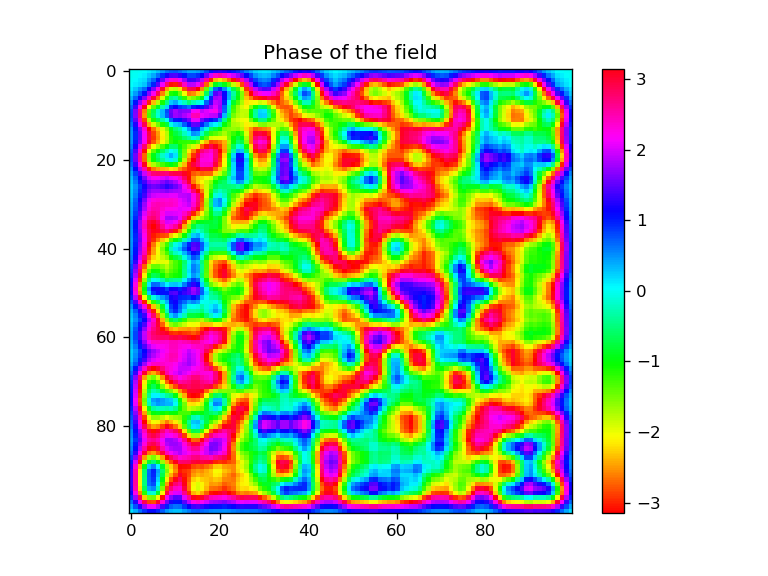

In [4]:
np_arr = np.angle(C[0,0,...].detach().numpy())
plt.figure()
plt.imshow(np_arr, interpolation = 'None', cmap = 'hsv')
plt.title('Phase of the field')
plt.colorbar()

## 3. Use phase layer in a model to optimize something

In [5]:
from PyTorchAberrations.aberration_layers import FreeSpacePropagation, FreeSpacePropagationFunction

### Create a model that simulate the transmission by a phase plate and then the propagation in free space for a fixed distance

The only trainable parameters are the one of the phase plate

In [6]:
class Propag_1plane(nn.Module):
    def __init__(self, shape, dx, lambda_, corr_length, z_final):
        super(Propag_1plane, self).__init__()
#         self.fsp = FreeSpacePropagation(dx = dx,
#                                         lambda_ = lambda_,
#                                         z_init_value = 0.)
        self.pp = PhasePlane(shape = shape, 
                             corr_length = 5, 
                             dx = dx, 
                             init_to_zero = True)
        
        self.z_final = z_final
        self.dx = dx
        self.lambda_ = lambda_
        
    def forward(self,input):
        input = self.pp(input)
        # free space propagation is here only a function, 
        # not a module, no parameters to be learned
        input = FreeSpacePropagationFunction.apply(input, 
                                                   torch.tensor(self.z_final), 
                                                   torch.tensor(self.dx), 
                                                   torch.tensor(self.lambda_)
                                                   ) 
        return input

Create the model

In [7]:
model = Propag_1plane(shape = shape,
                     dx = 1,
                     lambda_ = 1,
                     corr_length = 5,
                     z_final = 400)

Input field: plane wave

In [8]:
E0 = torch.ones(*shape).type(torch.complex64)[None,None,...]
Eout_before = model(E0)

### Output intensity pattern before optimization

<IPython.core.display.Javascript object>


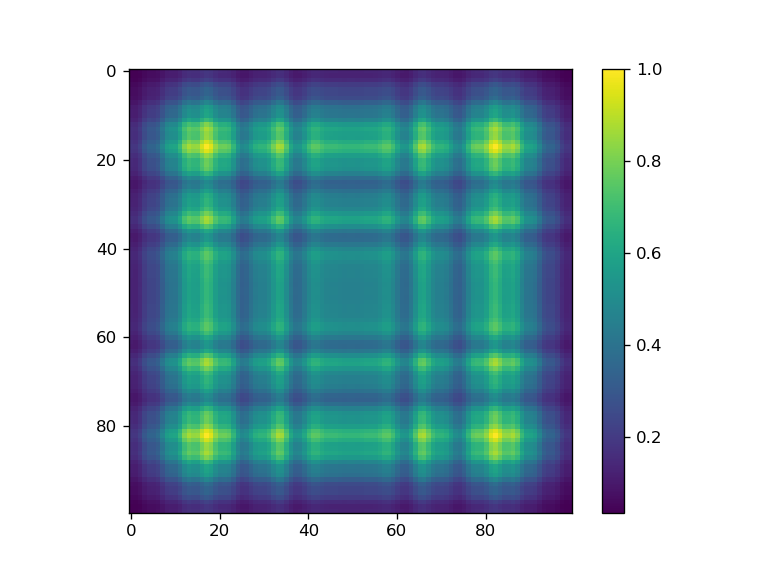

In [9]:
Iout_before = np.abs(Eout_before.detach().numpy())[0,0,...]**2
Iout_before = Iout_before/np.max(Iout_before)
plt.figure()
plt.imshow(Iout_before)
plt.colorbar()

### Optimization

In [10]:
learning_rate = 1e-1
num_epoch = 10
target = [s//2 for s in shape]

Optimizer

In [11]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate
)

**Optimization loop**

The cost function maximized the intensity at a target position divided by the mean intensity.

We want the system to find the phase mask that focuses on the target.

In [12]:
for epoch in range(num_epoch):

    # 
    Eout = model(E0)
    # intensity at the target point
    Itarget = torch.abs(Eout[0,0,target[0],target[1]])**2
    Ibackground = torch.mean(torch.abs(Eout)**2)
    
    loss = Ibackground/Itarget
    
    print(f"Epoch: {epoch}/{num_epoch}\t loss:{loss.item()}")

    optimizer.zero_grad() 
    # backward propagation done by autograd
    loss.backward()

    # update the parameters
    optimizer.step()

Epoch: 0/10	 loss:0.9275826215744019


/opt/miniconda/envs/py38/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370124688/work/aten/src/ATen/native/Copy.cpp:162.)
  Variable._execution_engine.run_backward(


Epoch: 1/10	 loss:0.25520390272140503
Epoch: 2/10	 loss:0.13798590004444122
Epoch: 3/10	 loss:0.09374033659696579
Epoch: 4/10	 loss:0.07127011567354202
Epoch: 5/10	 loss:0.057898130267858505
Epoch: 6/10	 loss:0.04911532998085022
Epoch: 7/10	 loss:0.04294554144144058
Epoch: 8/10	 loss:0.03839534521102905
Epoch: 9/10	 loss:0.03491361811757088


### Show results

<IPython.core.display.Javascript object>


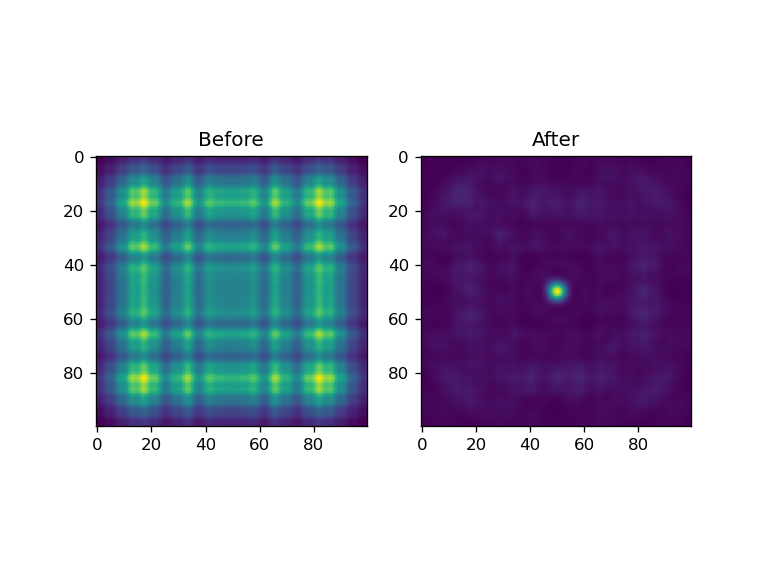

Text(0.5, 1.0, 'After')

In [13]:
Eout_after = model(E0)
Iout_after = np.abs(Eout.detach().numpy())[0,0,...]**2
Iout_after = Iout_after/np.max(Iout_after)
plt.figure()
plt.subplot(121)
plt.imshow(Iout_before)
plt.title('Before')
plt.subplot(122)
plt.imshow(Iout_after)
plt.title('After')
# plt.colorbar()

### Show optimized phase mask

<IPython.core.display.Javascript object>


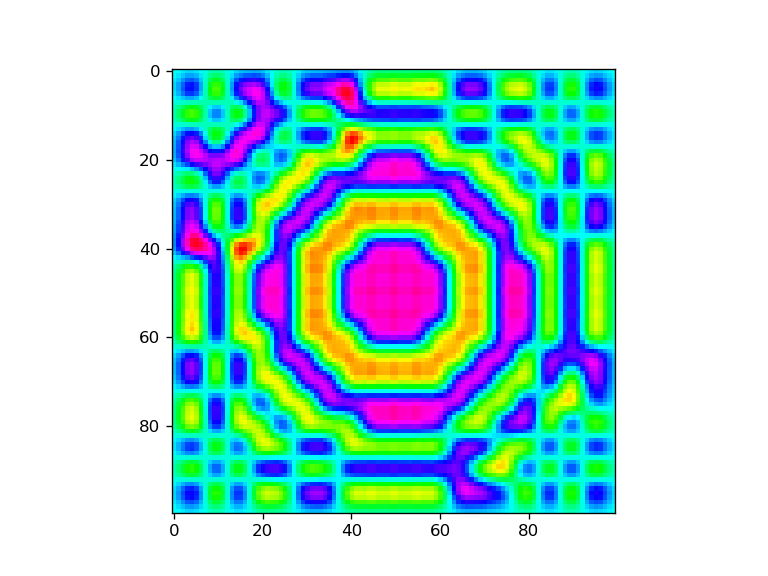

In [14]:
phase_plane = model.pp.get_phase_map().detach().numpy()[0,0]

plt.figure()
plt.imshow(phase_plane, cmap = 'hsv')